In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
mnist = tf.keras.datasets.mnist

In [4]:
data_dir = "../data/mnist"
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

#### Sanity Check

Batch Shape: (3, 28, 28)
Letter: 0


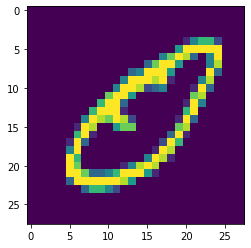

In [5]:
x, y = train_ds.__iter__().next()
sample = x[0]
label = y[0]
print("Batch Shape: {}".format(x.shape))
print("Letter: {}".format(label))
plt.imshow(sample)

In [6]:
READ_ATTN = True
WRITE_ATTN = True

In [97]:
A, B = 28, 28  # image width,height
img_size = B * A  # the canvas size
enc_size = 256  # number of hidden units / output size in LSTM
dec_size = 256

# Glimpse grid dimensions ASSUMED TO BE ODD
read_n = 5  # read glimpse grid width/height
write_n = 5  # write glimpse grid width/height
read_size = 2 * read_n * read_n if READ_ATTN else 2 * img_size
write_size = write_n * write_n if WRITE_ATTN else img_size

z_size = 10  # QSampler output size
SEQ_LENGTH = 10  # MNIST generation sequence length

BATCH_SIZE = 3
BUFFER_SIZE = 10000

train_iters = 10000
learning_rate = 1e-3  # learning rate for optimizer
eps = 1e-8  # epsilon for numerical stability

In [48]:
def filterbank(gx, gy, sigma2, delta, N):
    # Grid is 0-indexed, but formula is 1-indexed...
    grid_i = tf.reshape(tf.cast(tf.range(1, N+1), tf.float32), [1, -1])
    mu_x = gx + (grid_i - N / 2 - 0.5) * delta  # eq 19
    mu_y = gy + (grid_i - N / 2 - 0.5) * delta  # eq 20
    a_range = tf.reshape(tf.cast(tf.range(A), tf.float32), [1, 1, -1])
    b_range = tf.reshape(tf.cast(tf.range(B), tf.float32), [1, 1, -1])
    mu_x = tf.reshape(mu_x, [-1, N, 1])
    mu_y = tf.reshape(mu_y, [-1, N, 1])
    sigma2 = tf.reshape(sigma2, [-1, 1, 1])
    Fx = tf.exp(-tf.square(a_range - mu_x) / (2 * sigma2))
    Fy = tf.exp(-tf.square(b_range - mu_y) / (2 * sigma2))  # batch x N x B
    # normalize, sum over A and B dims
    Fx = Fx / tf.maximum(tf.reduce_sum(Fx, [1,2]), eps)
    Fy = Fy / tf.maximum(tf.reduce_sum(Fy, [1,2]), eps)
    return Fx, Fy

### Single sample check

## Batch sample check

In [51]:
Fx, Fy = filterbank(gx, gy, sigma2, delta, N)
Fx = tf.tile(Fx, [BATCH_SIZE, 1, 1])
Fy = tf.tile(Fy, [BATCH_SIZE, 1, 1])
sample_batch = tf.cast(x, tf.float32)

Fxt = tf.transpose(Fx, perm=[0, 2, 1])

glimpses = tf.linalg.matmul(Fy, tf.linalg.matmul(sample_batch, Fxt))
glimpses = tf.reshape(glimpses, [-1, N * N])
# print(Fxt.shape)
# print(Fy.shape)
# print(sample_batch.shape)
# print(Fx.shape)
print(glimpses.shape)

# for i in range(BATCH_SIZE):
#     plt.imshow(x[i])
#     plt.figure()
#     plt.imshow(glimpses[i])
#     plt.figure()

(3, 25)


In [ ]:
def gaussian_filterbank(gx, gy, sigma2, delta, N):
    # Grid is 0-indexed, but formula is 1-indexed...
    grid_i = tf.reshape(tf.cast(tf.range(1, N+1), tf.float32), [1, -1])
    mu_x = gx + (grid_i - N / 2 - 0.5) * delta  # eq 19
    mu_y = gy + (grid_i - N / 2 - 0.5) * delta  # eq 20
    a_range = tf.reshape(tf.cast(tf.range(A), tf.float32), [1, 1, -1])
    b_range = tf.reshape(tf.cast(tf.range(B), tf.float32), [1, 1, -1])
    mu_x = tf.reshape(mu_x, [-1, N, 1])
    mu_y = tf.reshape(mu_y, [-1, N, 1])
    sigma2 = tf.reshape(sigma2, [-1, 1, 1])
    Fx = tf.exp(-tf.square(a_range - mu_x) / (2 * sigma2))
    Fy = tf.exp(-tf.square(b_range - mu_y) / (2 * sigma2))  # batch x N x B
    # normalize, sum over A and B dims
    Fx = Fx / tf.maximum(tf.reduce_sum(Fx, [1,2]), eps)
    Fy = Fy / tf.maximum(tf.reduce_sum(Fy, [1,2]), eps)
    return Fx, Fy
    

In [122]:
class DRAWRNNCell(tf.keras.layers.Layer):
    
    def __init__(self,
                 output_dim,
                 state_dim,
                 read_attention=True,
                 write_attention=True,
                **kwargs):
        
        # Encoder/Decoder LSTM Cells track their own kernels
        self.lstm_encoder = tf.keras.layers.LSTMCell(enc_size, kernel_initializer="zeros")
        self.lstm_decoder = tf.keras.layers.LSTMCell(dec_size, kernel_initializer="zeros")
        
        self.use_read_attention = read_attention
        self.use_write_attention = write_attention
        
        self.output_size = output_dim
        self.state_size = state_dim
        
        super(DRAWRNNCell, self).__init__(**kwargs)

    def build(self, input_shape):
        
        self.attention_kernel = self.add_weight(
            shape=(self.output_size, self.output_size),
            initializer='glorot_uniform',
            name='W')
        
        self.attention_bias = self.add_weight(
            shape=(self.output_size, self.output_size),
            initializer='zeros',
            name='b')
        
        self.built = True

    def encode(self, input, state):
        return self.lstm_encoder(input, state)
    
    def decode(self, input, state):
        return self.lstm_decoder(input, state)
        
    def call(self, inputs, states):
        
#         import pdb; pdb.set_trace()
        
        c_prev, enc_prev, dec_prev = states
        x = inputs
        # Error image (3)
        x_hat = x - tf.sigmoid(c_prev)
        # Read (4)
        r = self.read(x, x_hat, dec_prev)
        # Encode (5)
        h_enc, enc_state = self.encode(tf.concat([r, dec_prev], 1), enc_prev)
        # Sample (6)
        z = sampleQ(h_enc)
#         z, mus[t], logsigmas[t], sigmas[t] = sampleQ(h_enc)
        # Decode (7)
        h_dec, dec_state = self.decode(z, dec_prev)
        # Write (8)
        c_out = c_prev + write(h_dec)
    
        # Return canvas as output & pass along as part of state
        return c_out, [c_out, h_enc, h_dec]
    
    def attn_window(self, h_dec, N):
        attention_params = tf.matmul(self.attention_kernel, h_dec) + self.attention_bias
        
        def filter_batch(batch, Fx, Fy, gamma, N):
            Fx = tf.tile(Fx, [BATCH_SIZE, 1, 1])
            Fy = tf.tile(Fy, [BATCH_SIZE, 1, 1])
            Fxt = tf.transpose(Fx, perm=[0, 2, 1])
            glimpses = tf.linalg.matmul(Fy, tf.linalg.matmul(sample_batch, Fxt))
            glimpses = tf.reshape(glimpse, [-1, N * N])
            return glimpses * gamma
        
        gx_, gy_, log_sigma2, log_delta, log_gamma = tf.split(attention_params, 5, 1)
        gx = (A + 1) / 2 * (gx_ + 1)
        gy = (B + 1) / 2 * (gy_ + 1)
        sigma2 = tf.exp(log_sigma2)
        delta = (max(A, B) - 1) / (N - 1) * tf.exp(log_delta)  # batch x N
        return gaussian_filterbank(gx, gy, sigma2, delta, N) + (tf.exp(log_gamma),)
    
    def read(self, x, x_hat, h_dec_prev):
        if self.use_read_attention:
            return self.read_attention(x, x_hat, h_dec_prev)
        else:
            return self.read_no_attention(x, x_hat, h_dec_prev)
        
    def read_no_attention(self, x, x_hat, h_dec_prev):
        return tf.concat([x, x_hat], 1)

    def read_attention(self, x, x_hat, h_dec_prev):
        Fx, Fy, gamma = self.attn_window(h_dec_prev, read_n)

        x = filter_img(x, Fx, Fy, gamma, read_n)  # batch x (read_n*read_n)
        x_hat = filter_img(x_hat, Fx, Fy, gamma, read_n)
        return tf.concat([x, x_hat], 1)  # concat along feature axis

In [123]:
cell = DRAWRNNCell(
    img_size,
    (img_size, enc_size, dec_size),
    read_attention=True,
    write_attention=True)

layer = tf.keras.layers.RNN(cell)

inputs = tf.keras.Input(batch_shape=(BATCH_SIZE, A, B))
x = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.RepeatVector(SEQ_LENGTH)(x)
y = layer(x)
model = Model(inputs=inputs, outputs=y)


ValueError: Dimensions must be equal, but are 784 and 3 for 'rnn_19/MatMul' (op: 'MatMul') with input shapes: [784,784], [3,256].

In [103]:
x.shape

TensorShape([3, 10, 784])